In [1]:
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

/home/qjy/anaconda3/envs/sccube/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = scCube()

In [3]:
sc_adata = sc.read_h5ad('/home/qjy/workspace/scCube/data/sc/Tabula_Muris_TM_facs_Brain_Non_Myeloid_adata.h5ad')

In [4]:
sc_adata.layers["log_transformed"] = sc_adata.X
sc_data = sc_adata.to_df(layer="log_transformed").T
sc_meta = sc_adata.obs

In [5]:
generate_sc_meta, generate_sc_data = model.load_vae_and_generate_cell(
    sc_adata=sc_adata,
    celltype_key='Cell_type',
    cell_key='Cell',
    target_num=None,
    hidden_size=128,
    load_path='/home/qjy/workspace/scCube/save_model/Tabula_Muris_TM_facs_Brain_Non_Myeloid_epoch10000.pth',
    used_device='cuda:1')

generating by the proportion of cell types of the input scRNA-seq data...
loading model from /home/qjy/workspace/scCube/save_model/Tabula_Muris_TM_facs_Brain_Non_Myeloid_epoch10000.pth
vae loading done!


Generate Epoch: 0: 100%|██████████| 3401/3401 [00:00<00:00, 3732.61it/s]


generated done!
data have been prepared!


In [6]:
sc.pp.highly_variable_genes(sc_adata, flavor="seurat_v3", n_top_genes=2000)
sc_adata = sc_adata[:, sc_adata.var.highly_variable]
sc.pp.scale(sc_adata, max_value=10)
sc.tl.pca(sc_adata, svd_solver='arpack')
sc.pp.neighbors(sc_adata)
sc.tl.umap(sc_adata)

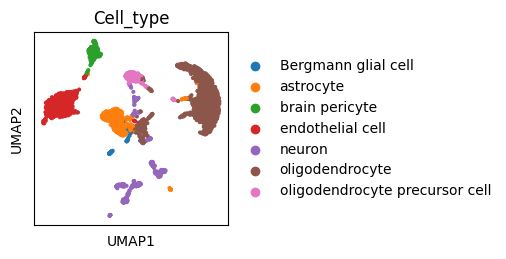

In [7]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata, color='Cell_type')

In [8]:
sc_adata_generate = model.pre_process(sc_data=generate_sc_data, 
                                      sc_meta=generate_sc_meta,
                                      is_normalized=True)

sc.pp.highly_variable_genes(sc_adata_generate, flavor="seurat_v3", n_top_genes=2000)
sc_adata_generate = sc_adata_generate[:, sc_adata_generate.var.highly_variable]
sc.pp.scale(sc_adata_generate, max_value=10)
sc.tl.pca(sc_adata_generate, svd_solver='arpack')
sc.pp.neighbors(sc_adata_generate)
sc.tl.umap(sc_adata_generate)

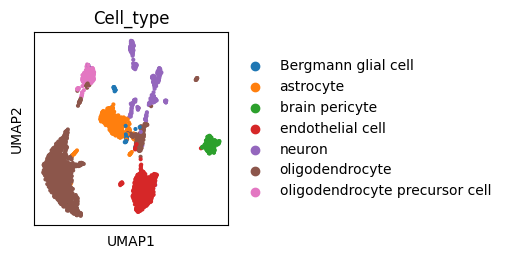

In [9]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata_generate, color='Cell_type')

In [10]:
adata_concat = sc_adata.concatenate(sc_adata_generate, batch_categories=['real', 'generate'])
sc.tl.pca(adata_concat)
# sc.external.pp.bbknn(adata_concat, batch_key='batch')  # running bbknn 1.3.6
sc.pp.neighbors(adata_concat)
sc.tl.umap(adata_concat)

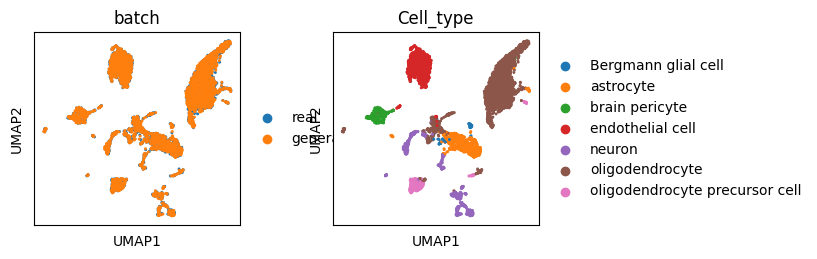

In [11]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(adata_concat, color=['batch', 'Cell_type'])

generating spatial coordinates of single cells...
generating spatial patterns of totally 7 cell types...
generating spot-based ST data with 5 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...
generating spatial coordinates of single cells...
generating spatial patterns of totally 7 cell types...
generating spot-based ST data with 10 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...
generating spatial coordinates of single cells...
generating spatial patterns of totally 7 cell types...
generating spot-based ST data with 15 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...
generating spatial coordinates of single cells...
generating spatial patterns of totally 7 cell types...
generating spot-based ST data with 20 cells per spot...
generating with the spot layou

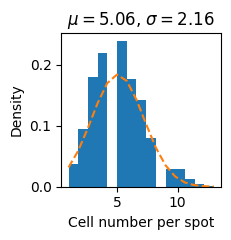

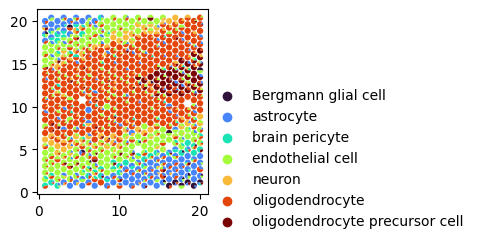

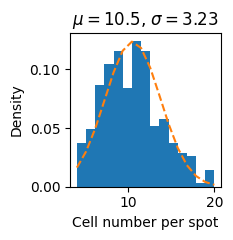

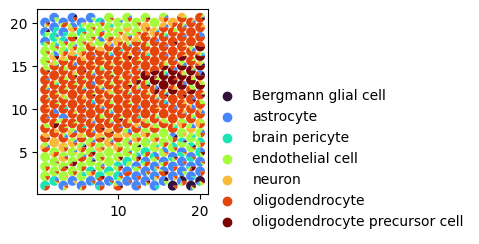

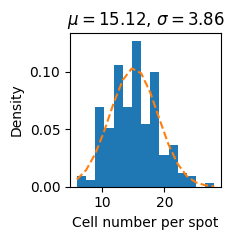

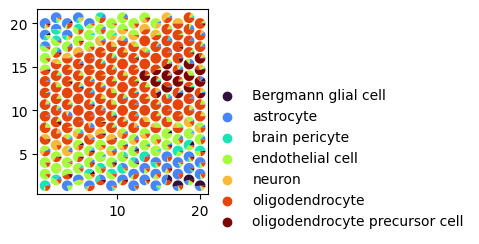

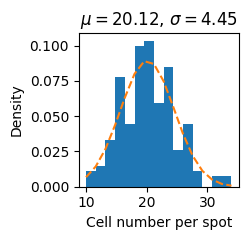

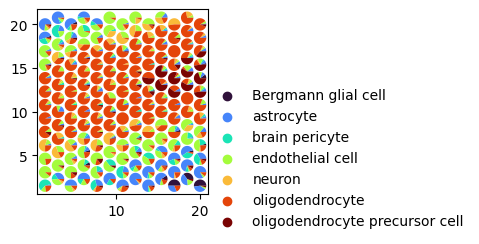

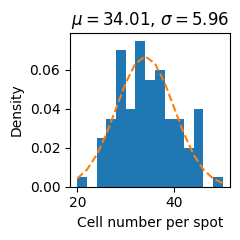

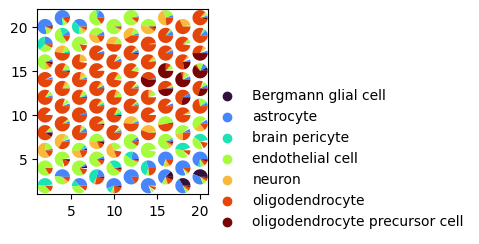

In [14]:
# n_cell
size_list = [20, 50, 60, 80, 120]
n_cell_list = [5, 10, 15, 20, 30]
for i in range(5):
    _, _, st_data, st_meta, st_index = model.generate_spatial_data_random(
        generate_sc_data=generate_sc_data,
        generate_sc_meta=generate_sc_meta,
        set_seed=True,
        seed=123,
        spatial_cell_type=None,
        spatial_dim=2,
        spatial_size=20,
        delta=15,
        lamda=0.75,
        is_spot=True,
        platform='Visium',
        gene_type='whole',
        min_cell=10,
        n_gene=None,
        n_cell=n_cell_list[i]
    )
    
    plot_spot_histplot(
        obj=st_index,
        figwidth=2.5,
        figheight=2.5,
        label='spot',
        n_bins=15)
    
    prop = calculate_spot_prop(
        obj=st_index,
        cell_id='Cell',
        label='Cell_type',
        spot_id='spot')
    
    plot_spot_scatterpie(
        obj=prop,
        figwidth=2.2,
        figheight=2.4,
        x="spot_x",
        y="spot_y",
        colormap='turbo',
        res=50,
        direction="+",
        start=0.0,
        size=size_list[i],
        edgecolor='none')
    
plt.show()

